In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten, concatenate, Lambda
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('https://media.githubusercontent.com/media/EthanRosehart/DS2_Assignments/refs/heads/main/final_dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Student_ID           1473 non-null   int64  
 1   Answer               1473 non-null   object 
 2   Age                  1473 non-null   int64  
 3   Gender               1473 non-null   object 
 4   CGPA                 1473 non-null   float64
 5   Stress_Level         1473 non-null   int64  
 6   Depression_Score     1473 non-null   int64  
 7   Anxiety_Score        1473 non-null   int64  
 8   Sleep_Quality        1473 non-null   object 
 9   Physical_Activity    1473 non-null   object 
 10  Diet_Quality         1473 non-null   object 
 11  Relationship_Status  1473 non-null   object 
 12  Financial_Stress     1473 non-null   int64  
 13  Negative_Emotion     1473 non-null   bool   
 14  Absences             1473 non-null   int64  
 15  Lates                1473 non-null   i

In [6]:
df['At_Risk'].value_counts()

At_Risk
0    1078
1     395
Name: count, dtype: int64

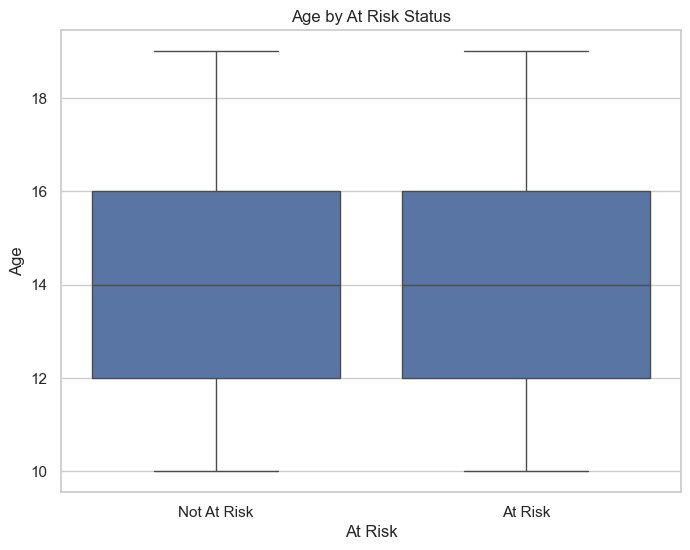

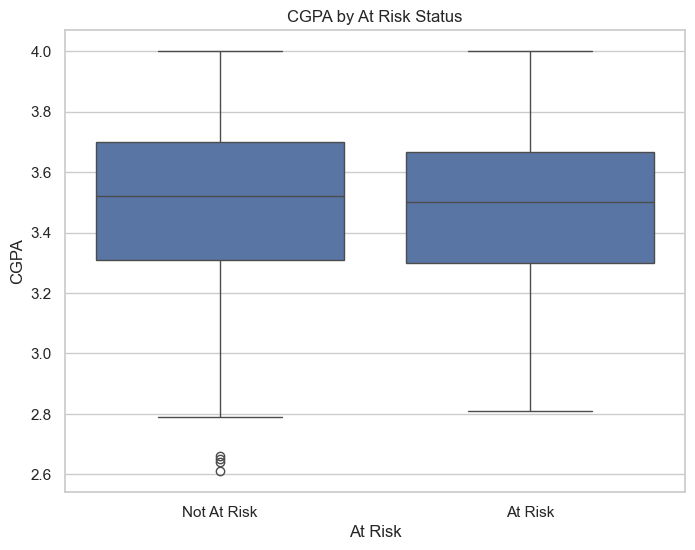

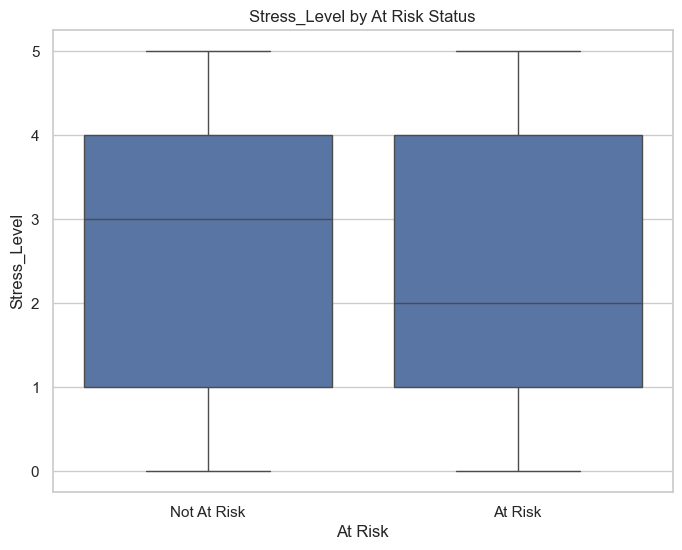

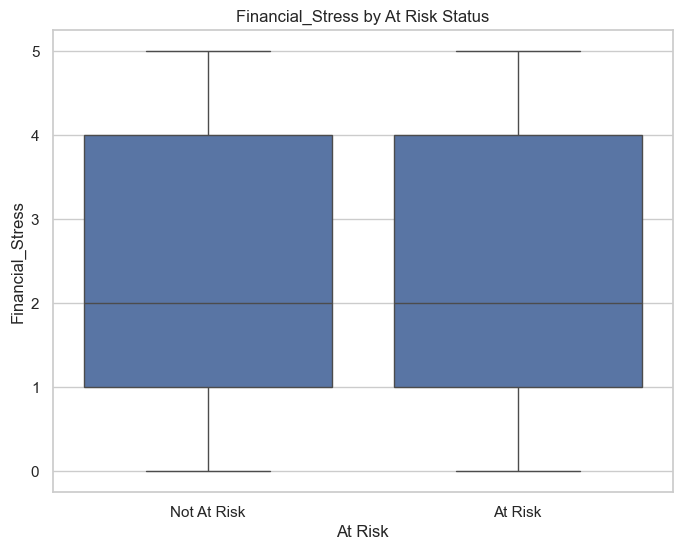

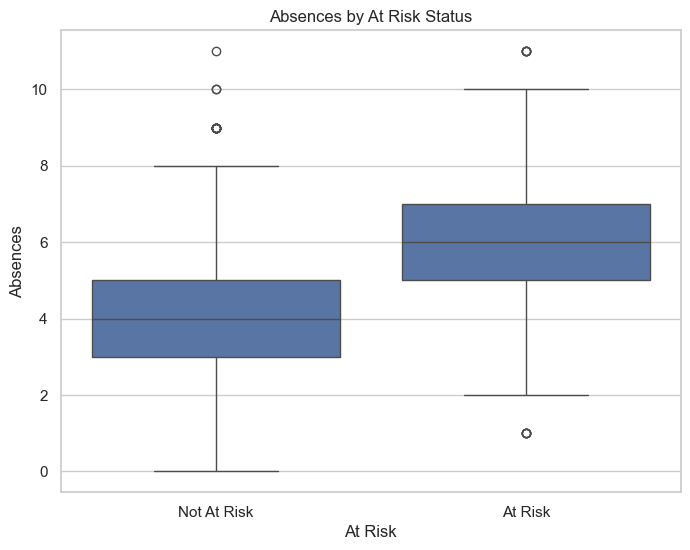

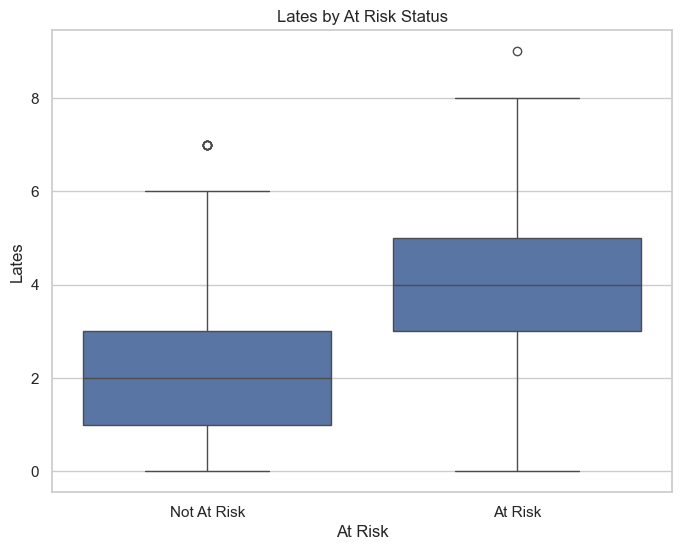

<Figure size 800x600 with 0 Axes>

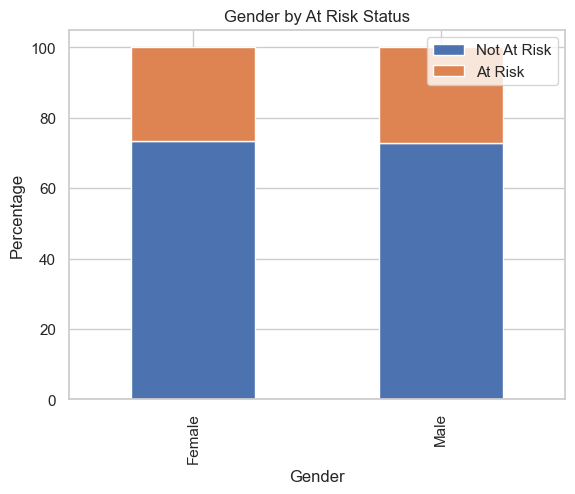

<Figure size 800x600 with 0 Axes>

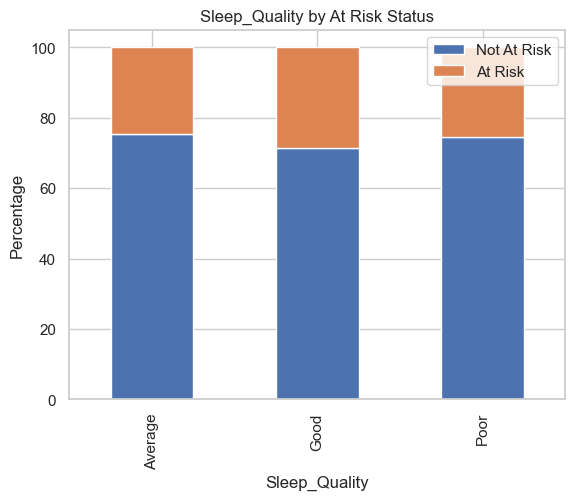

<Figure size 800x600 with 0 Axes>

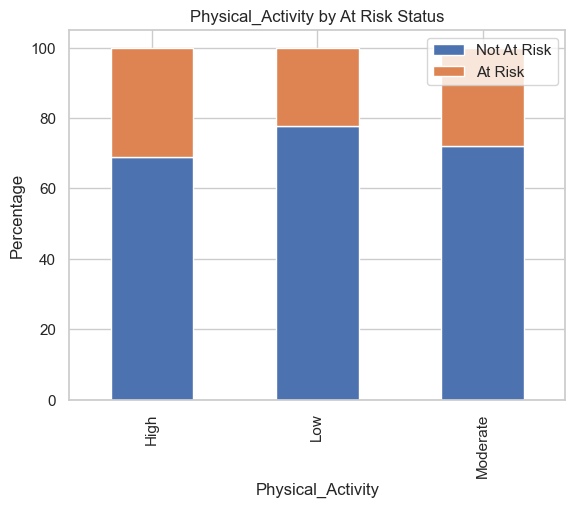

<Figure size 800x600 with 0 Axes>

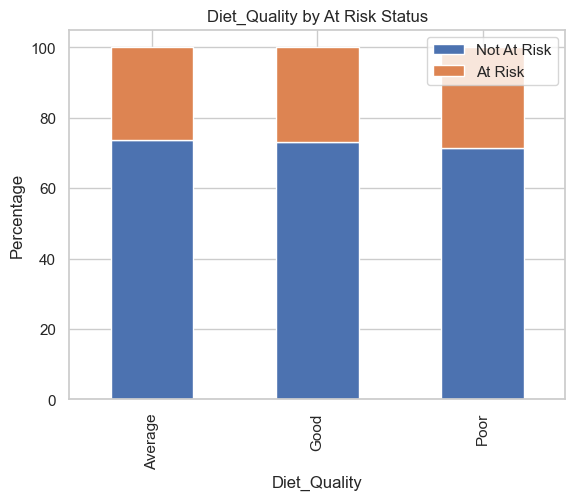

<Figure size 800x600 with 0 Axes>

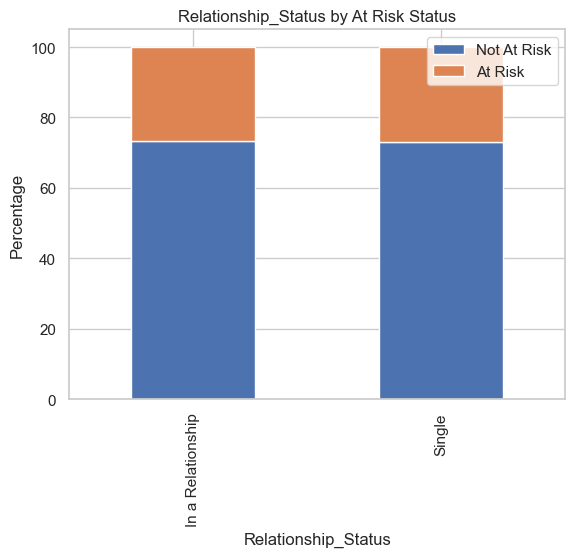

<Figure size 800x600 with 0 Axes>

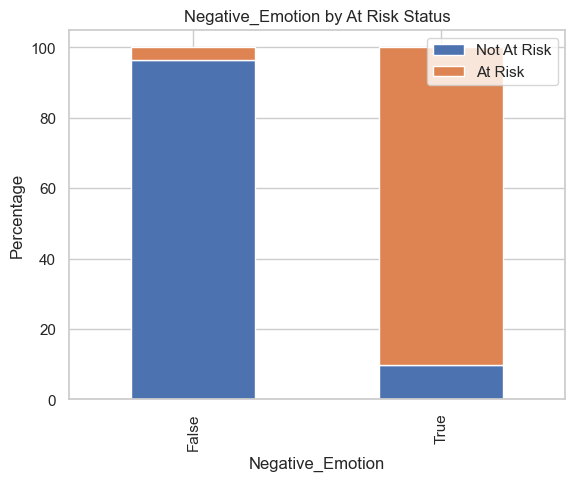

In [ ]:
# Exclude specified columns
columns_to_exclude = ['Student_ID', 'Answer', 'Depression_Score', 'Anxiety_Score', 'At_Risk']
columns_to_visualize = [col for col in df.columns if col not in columns_to_exclude]

# Separate numerical and categorical columns
numerical_columns = df[columns_to_visualize].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df[columns_to_visualize].select_dtypes(include=['object', 'bool', 'category']).columns.tolist()

# Set up the plotting environment
sns.set(style='whitegrid')

# Plot numerical columns
for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='At_Risk', y=col, data=df)
    plt.title(f'{col} by At Risk Status')
    plt.xlabel('At Risk')
    plt.ylabel(col)
    plt.xticks([0, 1], ['Not At Risk', 'At Risk'])
    plt.show()

# Plot categorical columns
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    # Calculate percentages
    prop_df = df.groupby([col, 'At_Risk']).size().reset_index(name='Count')
    prop_df = prop_df.pivot(index=col, columns='At_Risk', values='Count').fillna(0)
    prop_df = prop_df.apply(lambda x: x / x.sum() * 100, axis=1)
    prop_df.plot(kind='bar', stacked=True)
    plt.title(f'{col} by At Risk Status')
    plt.xlabel(col)
    plt.ylabel('Percentage')
    plt.legend(['Not At Risk', 'At Risk'])
    plt.show()


# First Model Test
* Removed Anxiety Score, Depression Score and Negative emotion (used to create the dataset)
* NLP to process the journal and Neural Network to process the rest
* Predicting Binary for At Risk

# LSTM + Neural Network

In [8]:
# Exclude Anxiety_Score, Depression_Score, and Negative_Emotion to create df_test
df_test = df.drop(columns=['Anxiety_Score', 'Depression_Score', 'Negative_Emotion'])

# Define input features and target
text_data = df['Answer']
structured_data = df.drop(columns=['Answer', 'Anxiety_Score', 'Depression_Score', 'Negative_Emotion', 'At_Risk'])
target = df['At_Risk']

# Split into train and test sets
X_text_train, X_text_test, X_struct_train, X_struct_test, y_train, y_test = train_test_split(
    text_data, structured_data, target, test_size=0.2, random_state=42
)

# Preprocessing for structured data
scaler = StandardScaler()
X_struct_train_scaled = scaler.fit_transform(X_struct_train.select_dtypes(include=['float64', 'int64']))
X_struct_test_scaled = scaler.transform(X_struct_test.select_dtypes(include=['float64', 'int64']))

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_struct_train_encoded = encoder.fit_transform(X_struct_train.select_dtypes(include=['object']))
X_struct_test_encoded = encoder.transform(X_struct_test.select_dtypes(include=['object']))

# Combine scaled and encoded structured data
X_struct_train_final = np.hstack([X_struct_train_scaled, X_struct_train_encoded])
X_struct_test_final = np.hstack([X_struct_test_scaled, X_struct_test_encoded])

# Preprocessing for text data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_train)
X_text_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_text_test_seq = tokenizer.texts_to_sequences(X_text_test)

max_seq_length = 100
X_text_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_text_train_seq, maxlen=max_seq_length, padding='post')
X_text_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_text_test_seq, maxlen=max_seq_length, padding='post')

# Define the NLP model
text_input = Input(shape=(max_seq_length,), name='text_input')
embedding = Embedding(input_dim=10000, output_dim=128)(text_input)
lstm = LSTM(64)(embedding)
text_output = Dense(32, activation='relu')(lstm)

# Define the structured data model
struct_input = Input(shape=(X_struct_train_final.shape[1],), name='struct_input')
dense1 = Dense(64, activation='relu')(struct_input)
dense2 = Dense(32, activation='relu')(dense1)
struct_output = Dense(16, activation='relu')(dense2)

# Combine the two models
combined = concatenate([text_output, struct_output])
dense_combined = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense_combined)
output = Dense(1, activation='sigmoid', name='output')(dropout)

# Build the model
model = Model(inputs=[text_input, struct_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_text_train_padded, X_struct_train_final], y_train,
    validation_data=([X_text_test_padded, X_struct_test_final], y_test),
    epochs=10, batch_size=32
)

# Evaluate the model
loss, accuracy = model.evaluate([X_text_test_padded, X_struct_test_final], y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Epoch 1/10


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'struct_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6279 - loss: 0.6422 - val_accuracy: 0.7390 - val_loss: 0.5530
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7352 - loss: 0.5574 - val_accuracy: 0.7458 - val_loss: 0.4916
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7849 - loss: 0.4698 - val_accuracy: 0.7831 - val_loss: 0.4734
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7824 - loss: 0.4523 - val_accuracy: 0.7797 - val_loss: 0.4723
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8262 - loss: 0.4061 - val_accuracy: 0.7797 - val_loss: 0.4758
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8334 - loss: 0.4157 - val_accuracy: 0.7695 - val_loss: 0.4917
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8280 - loss: 0.4095 - val_accuracy: 0.7864 - val_loss: 0.4793
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8382 - loss: 0.3868 - val_accuracy: 0.7661 - val_loss: 0.

In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle
import gradio as gr

# ============================
# Part 1: Training Script
# ============================

# Load your dataset
df = pd.read_csv('final_dataset.csv')

# Exclude 'Student_ID' from the dataset if it exists
if 'Student_ID' in df.columns:
    df = df.drop(columns=['Student_ID'])

# Define input features and target
text_data = df['Answer']
structured_data = df.drop(columns=['Answer', 'Anxiety_Score', 'Depression_Score', 'Negative_Emotion', 'At_Risk'])
target = df['At_Risk']

# Split into train and test sets
X_text_train, X_text_test, X_struct_train, X_struct_test, y_train, y_test = train_test_split(
    text_data, structured_data, target, test_size=0.2, random_state=42
)

# Identify numeric and categorical columns
numeric_columns = X_struct_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = X_struct_train.select_dtypes(include=['object']).columns.tolist()

# Exclude 'Student_ID' from numeric_columns if it somehow exists
if 'Student_ID' in numeric_columns:
    numeric_columns.remove('Student_ID')

# Save numeric and categorical column names
with open('numeric_columns.pkl', 'wb') as f:
    pickle.dump(numeric_columns, f)

with open('categorical_columns.pkl', 'wb') as f:
    pickle.dump(categorical_columns, f)

# Preprocessing for structured data
# Scale numeric data
scaler = StandardScaler()
X_struct_train_scaled_numeric = scaler.fit_transform(X_struct_train[numeric_columns])
X_struct_test_scaled_numeric = scaler.transform(X_struct_test[numeric_columns])

# Encode categorical data
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_struct_train_encoded_categorical = encoder.fit_transform(X_struct_train[categorical_columns])
X_struct_test_encoded_categorical = encoder.transform(X_struct_test[categorical_columns])

# Save the scaler and encoder
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

# Combine scaled numeric and encoded categorical data
X_struct_train_final = np.hstack([X_struct_train_scaled_numeric, X_struct_train_encoded_categorical])
X_struct_test_final = np.hstack([X_struct_test_scaled_numeric, X_struct_test_encoded_categorical])

# Preprocessing for text data
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text_train)

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

X_text_train_seq = tokenizer.texts_to_sequences(X_text_train)
X_text_test_seq = tokenizer.texts_to_sequences(X_text_test)

max_seq_length = 100
X_text_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_text_train_seq, maxlen=max_seq_length, padding='post')
X_text_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_text_test_seq, maxlen=max_seq_length, padding='post')

# Define the NLP model
text_input = Input(shape=(max_seq_length,), name='text_input')
embedding = Embedding(input_dim=10000, output_dim=128)(text_input)
lstm = LSTM(64)(embedding)
text_output = Dense(32, activation='relu')(lstm)

# Define the structured data model
struct_input = Input(shape=(X_struct_train_final.shape[1],), name='struct_input')
dense1 = Dense(64, activation='relu')(struct_input)
dense2 = Dense(32, activation='relu')(dense1)
struct_output = Dense(16, activation='relu')(dense2)

# Combine the two models
combined = concatenate([text_output, struct_output])
dense_combined = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense_combined)
output = Dense(1, activation='sigmoid', name='output')(dropout)

# Build the model
model = Model(inputs=[text_input, struct_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_text_train_padded, X_struct_train_final], y_train,
    validation_data=([X_text_test_padded, X_struct_test_final], y_test),
    epochs=10, batch_size=32
)

# Evaluate the model
loss, accuracy = model.evaluate([X_text_test_padded, X_struct_test_final], y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Save the trained model
model.save('risk_model.h5')

print("Model and preprocessing objects saved successfully.")

# ============================
# Part 2: Prediction Script with Gradio Interface
# ============================

# Load the saved model and preprocessors
model = load_model('risk_model.h5')

with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('encoder.pkl', 'rb') as f:
    encoder = pickle.load(f)
with open('numeric_columns.pkl', 'rb') as f:
    numeric_columns = pickle.load(f)
with open('categorical_columns.pkl', 'rb') as f:
    categorical_columns = pickle.load(f)

# Define the prediction function
def predict_risk(
    answer, age, gender, cgpa, stress_level, sleep_quality, physical_activity,
    diet_quality, relationship_status, financial_stress, absences, lates
):
    # Text preprocessing
    max_seq_length = 100  # Same as during training
    sequence = tokenizer.texts_to_sequences([answer])
    padded_sequence = tf.keras.preprocessing.sequence.pad_sequences(
        sequence, maxlen=max_seq_length, padding='post'
    )

    # Structured data preprocessing
    # Create a dictionary of input features
    numeric_features_dict = {
        'Age': age,
        'CGPA': cgpa,
        'Stress_Level': stress_level,
        'Financial_Stress': financial_stress,
        'Absences': absences,
        'Lates': lates,
        # Add any additional numeric features used during training
    }

    # Ensure the numeric features are in the correct order
    try:
        numeric_features = np.array([[numeric_features_dict[col] for col in numeric_columns]])
    except KeyError as e:
        return f"Error: Missing input for numeric feature '{e.args[0]}'. Please ensure all inputs are provided."

    numeric_features_scaled = scaler.transform(numeric_features)

    # Categorical features preprocessing
    categorical_features_dict = {
        'Gender': gender,
        'Sleep_Quality': sleep_quality,
        'Physical_Activity': physical_activity,
        'Diet_Quality': diet_quality,
        'Relationship_Status': relationship_status
        # Add any additional categorical features used during training
    }

    # Create DataFrame with the categorical features
    categorical_features_df = pd.DataFrame([categorical_features_dict])

    # Ensure columns are in the same order as during training
    categorical_features_df = categorical_features_df[categorical_columns]
    categorical_features_encoded = encoder.transform(categorical_features_df)

    # Combine numeric and categorical features
    structured_input = np.hstack([numeric_features_scaled, categorical_features_encoded])

    # Make prediction
    prediction = model.predict([padded_sequence, structured_input])
    risk_prob = prediction[0][0]

    # Interpret the result
    if risk_prob >= 0.5:
        result = f"At Risk (Probability: {risk_prob:.2f})"
    else:
        result = f"Not At Risk (Probability: {risk_prob:.2f})"

    return result

# Define the interface with corrected input components
iface = gr.Interface(
    fn=predict_risk,
    inputs=[
        gr.Textbox(
            lines=3,
            placeholder="Enter your journal entry here...",
            label="Journal Entry",
            type="text"
        ),
        gr.Number(
            label="Age",
            value=15,  # Default value
            precision=0,
            minimum=12,  # Adjusted minimum age based on your dataset
            maximum=20,
            step=1
        ),
        gr.Radio(
            choices=['Male', 'Female', 'Other'],
            label="Gender",
            type="value"
        ),
        gr.Number(
            label="CGPA",
            value=3.0,  # Default value
            precision=2,
            minimum=0.0,
            maximum=4.0,
            step=0.01
        ),
        gr.Slider(
            minimum=0,
            maximum=5,
            step=1,
            label="Stress Level",
            value=1  # Default value
        ),
        gr.Radio(
            choices=['Poor', 'Average', 'Good'],
            label="Sleep Quality",
            type="value"
        ),
        gr.Radio(
            choices=['Low', 'Moderate', 'High'],
            label="Physical Activity",
            type="value"
        ),
        gr.Radio(
            choices=['Poor', 'Average', 'Good'],
            label="Diet Quality",
            type="value"
        ),
        gr.Radio(
            choices=['Single', 'In a Relationship'],
            label="Relationship Status",
            type="value"
        ),
        gr.Slider(
            minimum=0,
            maximum=5,
            step=1,
            label="Financial Stress",
            value=1  # Default value
        ),
        gr.Number(
            label="Absences",
            value=0,  # Default value
            precision=0,
            minimum=0,
            maximum=50,  # Adjust as per your dataset
            step=1
        ),
        gr.Number(
            label="Lates",
            value=0,  # Default value
            precision=0,
            minimum=0,
            maximum=50,  # Adjust as per your dataset
            step=1
        )
    ],
    outputs=gr.Textbox(label="Prediction"),
    title="Risk Prediction",
    description="Enter your details and journal entry to predict whether you are at risk."
)

# Launch the interface
iface.launch(share=True)


Epoch 1/10


C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['text_input', 'struct_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7453 - loss: 0.6117 - val_accuracy: 0.7390 - val_loss: 0.5393
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7394 - loss: 0.5213 - val_accuracy: 0.7390 - val_loss: 0.4936
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7639 - loss: 0.4695 - val_accuracy: 0.7593 - val_loss: 0.4881
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8076 - loss: 0.4446 - val_accuracy: 0.7525 - val_loss: 0.4895
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8028 - loss: 0.4567 - val_accuracy: 0.7831 - val_loss: 0.4890
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8104 - loss: 0.4249 - val_accuracy: 0.7390 - val_loss: 0.5078
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8182 - loss: 0.4159 - val_accuracy: 0.7729 - val_loss: 0.5039
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8390 - loss: 0.3665 - val_accuracy: 0.7559 - val_loss: 0.


Model and preprocessing objects saved successfully.


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://b45aef3b93e067cca9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# BERT + Neural Network

In [60]:
# Load and split the data
df_test = df.drop(columns=['Anxiety_Score', 'Depression_Score', 'Negative_Emotion'])
df_test.to_csv("df_test.csv", index=False)

# Define input features and target
text_data = df['Answer']
structured_data = df.drop(columns=['Answer', 'Anxiety_Score', 'Depression_Score', 'Negative_Emotion', 'At_Risk'])
target = df['At_Risk']

# Split into train and test sets
X_text_train, X_text_test, X_struct_train, X_struct_test, y_train, y_test = train_test_split(
    text_data, structured_data, target, test_size=0.2, random_state=42
)

# Preprocessing for structured data
scaler = StandardScaler()
X_struct_train_scaled = scaler.fit_transform(X_struct_train.select_dtypes(include=['float64', 'int64']))
X_struct_test_scaled = scaler.transform(X_struct_test.select_dtypes(include=['float64', 'int64']))

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_struct_train_encoded = encoder.fit_transform(X_struct_train.select_dtypes(include=['object']))
X_struct_test_encoded = encoder.transform(X_struct_test.select_dtypes(include=['object']))

# Combine scaled and encoded structured data
X_struct_train_final = np.hstack([X_struct_train_scaled, X_struct_train_encoded])
X_struct_test_final = np.hstack([X_struct_test_scaled, X_struct_test_encoded])

# Preprocessing for BERT
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

def encode_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        list(texts),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="tf"
    )

X_text_train_encoded = encode_texts(X_text_train, tokenizer)
X_text_test_encoded = encode_texts(X_text_test, tokenizer)

# Load BERT model and tokenizer
bert_model_name = "bert-base-uncased"
bert_model = TFBertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Define inputs for the Keras Functional API
text_input_ids = Input(shape=(128,), dtype=tf.int32, name="input_ids")
text_attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

# Manually wrap BERT model in a Lambda layer to process inputs
def bert_layer(inputs):
    input_ids, attention_mask = inputs
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.pooler_output

# Add Lambda layer to preprocess inputs for BERT
bert_output = Lambda(
    bert_layer,
    output_shape=(768,),  # BERT's pooled output is 768-dimensional
)([text_input_ids, text_attention_mask])

text_output = Dense(64, activation="relu")(bert_output)

# Example structured data input
struct_input = Input(shape=(X_struct_train_final.shape[1],), name="struct_input")
struct_output = Dense(32, activation="relu")(struct_input)

# Combine text and structured data outputs
combined = concatenate([text_output, struct_output])
dense_combined = Dense(64, activation="relu")(combined)
dropout = Dropout(0.5)(dense_combined)
output = Dense(1, activation="sigmoid")(dropout)

# Build the model
model = Model(inputs=[text_input_ids, text_attention_mask, struct_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()


# Define the structured data model
struct_input = Input(shape=(X_struct_train_final.shape[1],), name='struct_input')
dense1 = Dense(64, activation='relu')(struct_input)
dense2 = Dense(32, activation='relu')(dense1)
struct_output = Dense(16, activation='relu')(dense2)

# Combine the two models
combined = concatenate([text_output, struct_output])
dense_combined = Dense(64, activation='relu')(combined)
dropout = Dropout(0.5)(dense_combined)
output = Dense(1, activation='sigmoid', name='output')(dropout)

# Build the combined model
model = Model(inputs=[text_input_ids, text_attention_mask, struct_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [X_text_train_encoded['input_ids'], X_text_train_encoded['attention_mask'], X_struct_train_final],
    y_train,
    validation_data=(
        [X_text_test_encoded['input_ids'], X_text_test_encoded['attention_mask'], X_struct_test_final], y_test
    ),
    epochs=3, batch_size=16
)

# Evaluate the model
loss, accuracy = model.evaluate(
    [X_text_test_encoded['input_ids'], X_text_test_encoded['attention_mask'], X_struct_test_final],
    y_test
)
print(f"Test Accuracy: {accuracy:.2f}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 768)       │          0 │ input_ids[0][0],  │
│                     │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ struct_input        │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 64)        │     49,216 │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 32)        │        672 │ struct_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 96)        │          0 │ dense_41[0][0],   │
│ (Concatenate)       │                   │            │ dense_42[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 64)        │      6,208 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_43[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 1)         │         65 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,161 (219.38 KB)

 Trainable params: 56,161 (219.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.6919 - loss: 0.6318 - val_accuracy: 0.7390 - val_loss: 0.5339
Epoch 2/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7827 - loss: 0.4763 - val_accuracy: 0.7763 - val_loss: 0.4729
Epoch 3/3
74/74 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7998 - loss: 0.4579 - val_accuracy: 0.7898 - val_loss: 0.4753
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.7790 - loss: 0.4882
Test Accuracy: 0.79
